In [392]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
import folium
from sklearn import preprocessing
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.colors as colors

In [393]:
en='environment/'
BB='Burning_biomass.csv'
EAT='Emissions_Agriculture_Total.csv'
EI='Emissions_intensities.csv'
EESAD='Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv'
FA='Fertilizers_archive.csv'
FN='Fertilizers_nutrient.csv'
FP='Fertilizers_product.csv'
LU='Land_use.csv'
LU2='Land_use_2.csv'
PU='Pesticides_use.csv'
TC='Temperature_change.csv'

In [394]:
world_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = set(world_df['name'])

# 'Emission_agriculture_total.csv'
Now I look into the Total emissions in agriculture database

In [748]:
eat=pd.read_csv(en+'Emissions_Agriculture_Agriculture_total_E_All_Data_NOFLAG.csv',encoding = "ISO-8859-1")

In [749]:
eat.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2030,Y2050
0,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),gigagrams,240.6831,245.3106,255.8285,...,401.0680,402.5130,396.9210,393.0930,398.2870,384.1370,381.6789,371.9253,453.7474,603.6185
1,2,Afghanistan,5058,Enteric Fermentation,7231,Emissions (CO2eq),gigagrams,5054.3459,5151.5228,5372.3989,...,8422.4280,8452.7730,8335.3410,8254.9530,8364.0270,8066.8761,8015.2578,7810.4313,9528.6962,12675.9880
2,2,Afghanistan,5058,Enteric Fermentation,7244,Emissions (CO2eq) from CH4,gigagrams,5054.3459,5151.5228,5372.3989,...,8422.4280,8452.7730,8335.3410,8254.9530,8364.0270,8066.8761,8015.2578,7810.4313,9528.6962,12675.9880
3,2,Afghanistan,5059,Manure Management,7225,Emissions (CH4),gigagrams,11.6228,11.9632,12.6064,...,26.5669,26.1599,26.0913,26.0859,26.3682,24.9017,24.7679,23.7619,27.2114,35.2700
4,2,Afghanistan,5059,Manure Management,7231,Emissions (CO2eq),gigagrams,367.8310,376.4362,392.5811,...,681.2759,678.8488,672.3300,667.6991,675.6191,645.1936,641.9611,623.3735,750.3240,1003.2279


In [750]:
eat = eat[eat.Element=='Emissions (CO2eq)']

In [751]:
eat_live_stock = eat[(eat.Item=='Enteric Fermentation')\
                     | (eat.Item=='Manure Management')\
                     | (eat.Item=='Manure left on Pasture')]

In [752]:
eat_agriculture = eat[(eat.Item=='Synthetic Fertilizers')\
                     | (eat.Item=='Manure applied to Soils')\
                     | (eat.Item=='Crop Residues')\
                     | (eat.Item=='Burning - Crop residues')\
                     | (eat.Item=='Burning - Savanna')\
                     | (eat.Item=='Rice Cultivation')\
                     | (eat.Item=='Cultivation of Organic Soils')]

In [753]:
years = ['Y'+str(1900+x) for x in range(61,100)]+ ['Y2030','Y2050']
to_drop = ['Area Code','Item Code','Element Code']

In [754]:
result = clean_df(eat_live_stock,years,to_drop,changes)

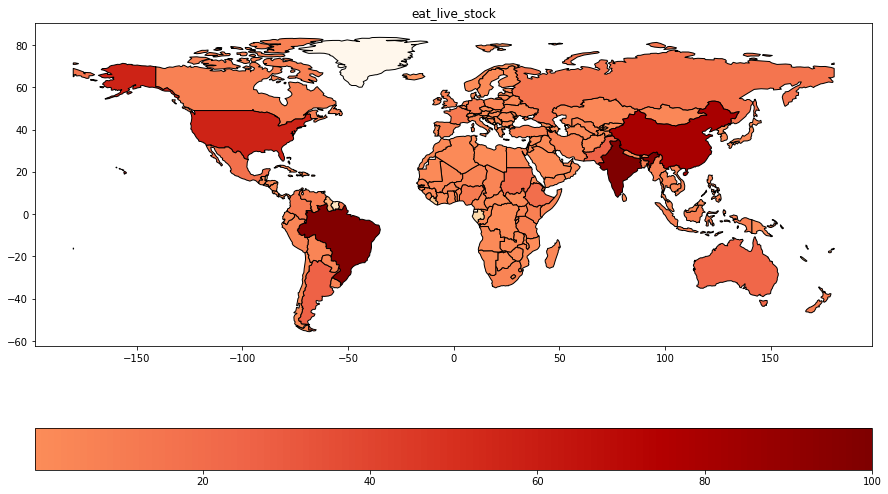

In [755]:
mapp(result, 'eat_live_stock')

In [756]:
result = clean_df(eat_agriculture,years,to_drop,changes)

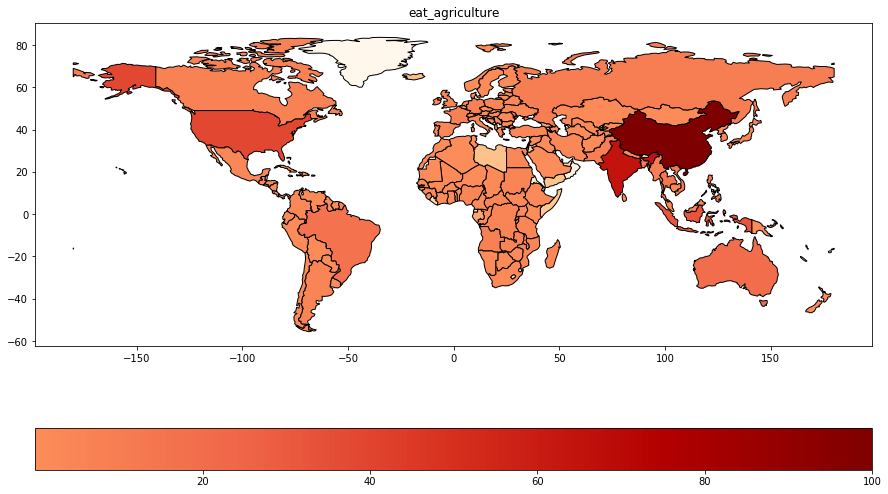

In [757]:
mapp(result, 'eat_agriculture')

In [758]:
eat_live_stock_interactive = interactive_df(eat_live_stock)

In [759]:
df = eat_live_stock_interactive
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
range_year = (min(df['YEAR']),max(df['YEAR']))
def plot_func(year):
    result = df
    result = result.set_index('Area')
    result = result[result['YEAR']==year]
    result = result.drop('YEAR', axis=1)
    mapp_interactive(result)

interact(plot_func,year = range_year)

interactive(children=(IntSlider(value=2005, description='year', max=2050, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [760]:
eat_agriculture_interactive = interactive_df(eat_agriculture)

In [761]:
df = eat_agriculture_interactive
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
range_year = (min(df['YEAR']),max(df['YEAR']))
def plot_func(year):
    result = df
    result = result.set_index('Area')
    result = result[result['YEAR']==year]
    result = result.drop('YEAR', axis=1)
    mapp_interactive(result)

interact(plot_func,year = range_year)

interactive(children=(IntSlider(value=2005, description='year', max=2050, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

# Fertilizers
Now we will evaluate the fertilizers datasets in order to eventually evaluate its correlation with the CO2 production.


In [730]:
fa = pd.read_csv(en+'Inputs_FertilizersArchive_E_All_Data.csv', encoding = "ISO-8859-1")
fn = pd.read_csv(en+'Inputs_FertilizersNutrient_E_All_Data_NOFLAG.csv', encoding = "ISO-8859-1")

In [731]:
fa = fa[fa['Element']=='Agricultural Use']
fn = fn[fn['Element']=='Agricultural Use']

In [734]:
def clean_df(df,years,to_drop,changes):
    df= df.replace(changes)
    df = df.drop(years, axis=1)
    df = df.groupby('Area').sum()
    df = df.drop(to_drop, axis=1)
    to_delete = set(df.index).difference(countries)
    df = df.drop(to_delete, axis=0)
    df['tot'] = 0
    df['tot'] = df.apply(norm).sum(axis=1)
    df = df.sort_values(by=['tot'], ascending=0)
    df = df[['tot']]
    df['tot'] = df['tot']*100/max(df['tot'])
    return df

In [735]:
years = []#['Y'+str(1900+x) for x in range(61,100)] + ['Y'+str(1900+x)+'F' for x in range(61,100)] +['Y'+str(2000+x)+'F' for x in range(0,3)]
to_drop = ['Area Code','Item Code','Element Code']

In [736]:
result = clean_df(fn,years,to_drop,changes)

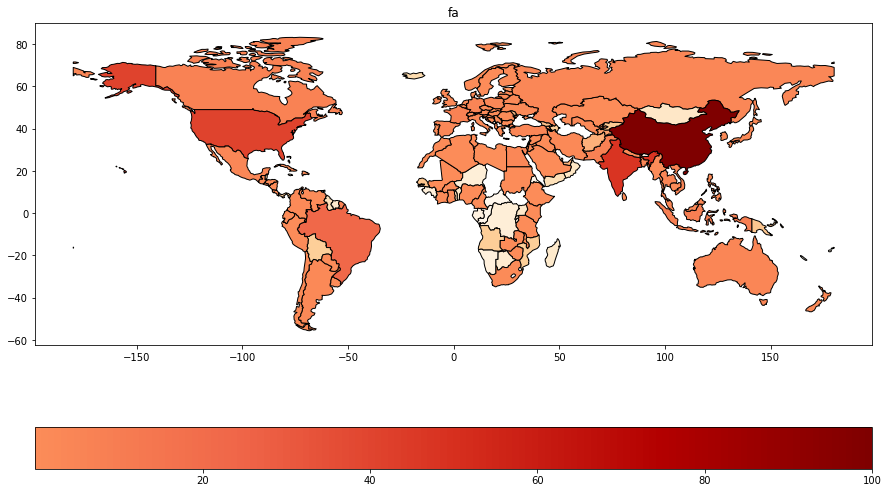

In [737]:
mapp(result,'fa')

In [690]:
def interactive_df(df, changes =changes, to_drop=to_drop):
    df= df.replace(changes)
    df = df.drop(to_drop, axis=1)
    df = df.groupby('Area').sum()
    to_delete = set(df.index).difference(countries)
    df = df.drop(to_delete, axis=0)
    df = df.apply(norm)*100
    df.columns = df.columns.str.replace('Y', '')
    df = df.stack()
    df = df.reset_index()
    df = df.rename(columns={'level_1': 'YEAR', 0: 'tot'})
    df['YEAR'] = df['YEAR'].astype(int)
    return df

In [691]:
years = ['Y'+str(1900+x)+'F' for x in range(61,100)] +['Y'+str(2000+x)+'F' for x in range(0,3)]
fa = fa.drop(years, axis=1)

In [692]:
fa_interactive = interactive_df(fa)

In [693]:
fn_interactive = interactive_df(fn)

In [696]:
fertilize = fn_interactive.append(fa_interactive)

In [697]:
def mapp_interactive(result, world_df=world_df):
    merged = world_df.set_index('name').join(result)
    merged = merged.dropna(subset=['tot'])
    vmin, vmax, vcenter = merged.tot.min(), merged.tot.max(), 0.1
    divnorm = colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    ax = merged.plot(column='tot', figsize=(15,10),  k=9,norm=divnorm,cmap='Greens', linewidth=1,edgecolor = "black",
                     legend=True,
                      legend_kwds={'orientation': "horizontal"})
    return

In [698]:
df = fertilize
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
range_year = (min(df['YEAR']),max(df['YEAR']))
def plot_func(year):
    result = df
    result = result.set_index('Area')
    result = result[result['YEAR']==year]
    result = result.drop('YEAR', axis=1)
    mapp_interactive(result)

interact(plot_func,year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [738]:
pesticides = pd.read_csv(en+'Inputs_Pesticides_Use_E_All_Data_NOFLAG.csv', encoding = "ISO-8859-1")

In [739]:
pesticides.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1990,Y1991,Y1992,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,3,Albania,1357,Pesticides (total),5157,Agricultural Use,tonnes,121.0,121.0,121.0,...,392.6,403.49,582.93,574.62,353.05,441.53,447.89,590.41,656.52,681.14
1,3,Albania,1309,Insecticides,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,213.88,375.80,317.07,157.57,214.13,34.48,184.59,226.30,237.59
2,3,Albania,1310,Insecticides  Chlorinated Hydrocarbons,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Albania,1311,Insecticides  Organo-phosphates,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,Albania,1312,Insecticides  Carbamates,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [740]:
pesticides = pesticides[pesticides.Item=='Pesticides (total)']

In [742]:
years = ['Y'+str(1900+x) for x in range(90,100)]# + ['Y'+str(1900+x)+'F' for x in range(61,100)] +['Y'+str(2000+x)+'F' for x in range(0,3)]
to_drop = ['Area Code','Item Code','Element Code']

In [744]:
result = clean_df(pesticides,years,to_drop,changes)

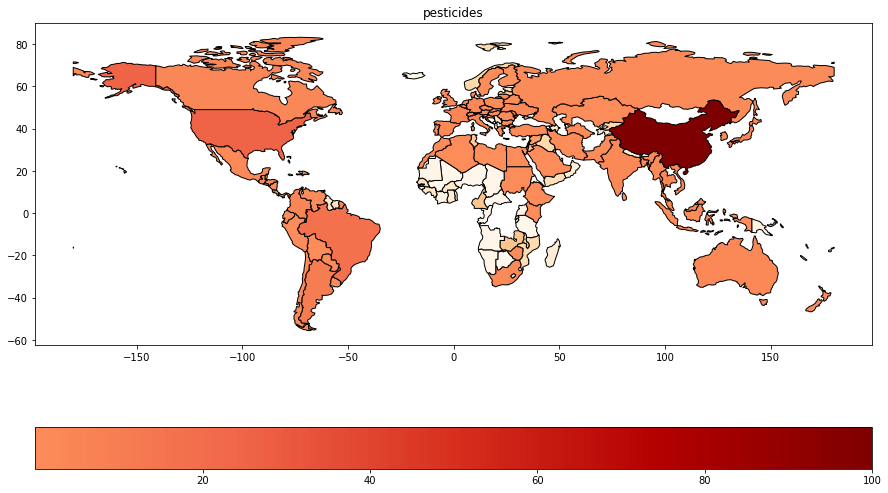

In [745]:
mapp(result,'pesticides')

In [746]:
pesticides_interactive = interactive_df(pesticides)

In [747]:
df = pesticides_interactive
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
range_year = (min(df['YEAR']),max(df['YEAR']))
def plot_func(year):
    result = df
    result = result.set_index('Area')
    result = result[result['YEAR']==year]
    result = result.drop('YEAR', axis=1)
    mapp_interactive(result)

interact(plot_func,year = range_year)

interactive(children=(IntSlider(value=2003, description='year', max=2017, min=1990), Output()), _dom_classes=(…

<function __main__.plot_func(year)>